# Proyecto Python Fundamentals - Roel Sedano
## CitiBike Demo
## Se creo un ambiente de Snowflake para el proyecto
## El objetivo es conectarnos desde un jupyter Notebook a la bd de Citibike utilizando el framework de snowpark para python y dar visibiliadad al Negocio.
### Ref: Curso Python Fundamentals, Zero to snowflake quickstart y Snowpark Developer Guide for Python

## Snowflake
<a href="https://docs.snowflake.com/"> Liga</a>

<img src="snowflake.png" width="615" height="383">

## Citibike Demo

<img src="citibike.jpg" width="690" height="358">

### Snowpak Imports

In [1]:
# Snowpark Imports
import json
from decimal import Decimal
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T

import pandas as pd
import numpy as np

# import networkx as nx
import itertools
from typing import Iterable, Tuple

import matplotlib.pyplot as plt



### Reading Snowflake Connection Details from JSON file

In [2]:
# Reading Snowflake Connection Details from JSON file
# usr, pwd, account, warehouse, db, schema

snowflake_connection_cfg = open('creds.json')
snowflake_connection_cfg = snowflake_connection_cfg.read()
snowflake_connection_cfg = json.loads(snowflake_connection_cfg)



### Creating Snowpark Session

In [3]:
# Creating Snowpark Session
session = Session.builder.configs(snowflake_connection_cfg).create()
print('Current Database:', session.get_current_database())
print('Current Schema:', session.get_current_schema())
print('Current Warehouse:', session.get_current_warehouse())

Current Database: "CITIBIKE"
Current Schema: "DEMO"
Current Warehouse: "BI_MEDIUM_WH"


# Consultar datos de Snowflake

In [4]:
df_sql =  session.sql("Select START_STATION_ID, END_STATION_ID, NUM_TRIPS,AVG_DURATION_MINS from CITIBIKE.DEMO.VIEW_POPULAR_ROUTES")
# df_sql.show()

In [5]:
df_PopularRoutes = df_sql.toPandas().sort_values("NUM_TRIPS", ascending=False)

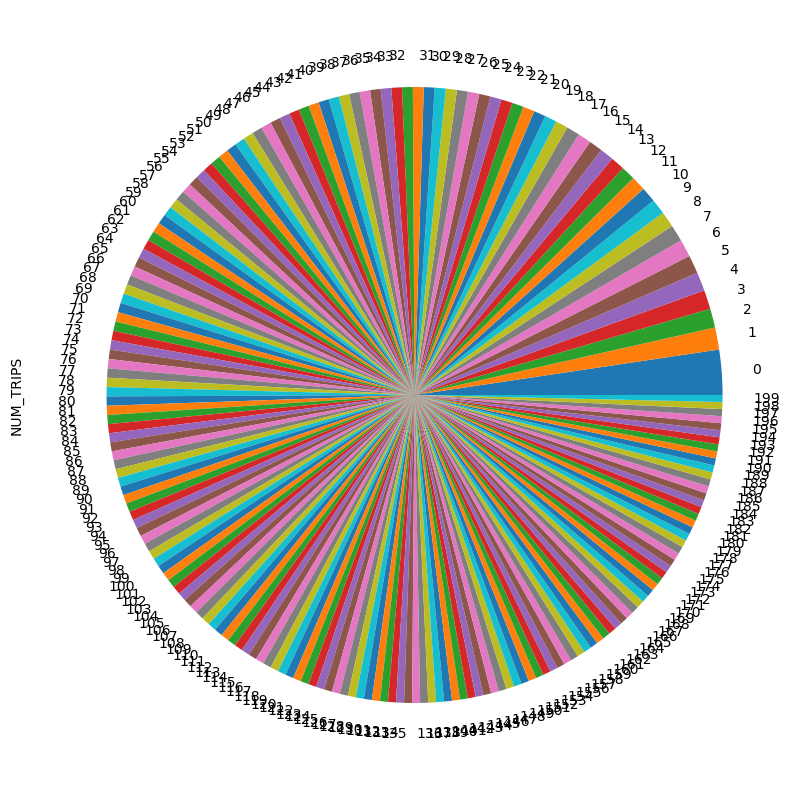

In [6]:
df_PopularRoutes_plot=df_PopularRoutes["NUM_TRIPS"].plot.pie(figsize=(10,10))

### Total de viajes Citibike

In [7]:
x=df_PopularRoutes["NUM_TRIPS"].sum()

In [8]:
x

49065079

### Timeline

In [9]:
df_sql_timeline =  session.sql("Select DIA, NUM_TRIPS from CITIBIKE.DEMO.VIEW_TIMELINE")


In [10]:
df_timeline = df_sql_timeline.toPandas()

In [11]:
df_timeline["DIA"].min()

datetime.date(2013, 6, 1)

<Axes: xlabel='DIA'>

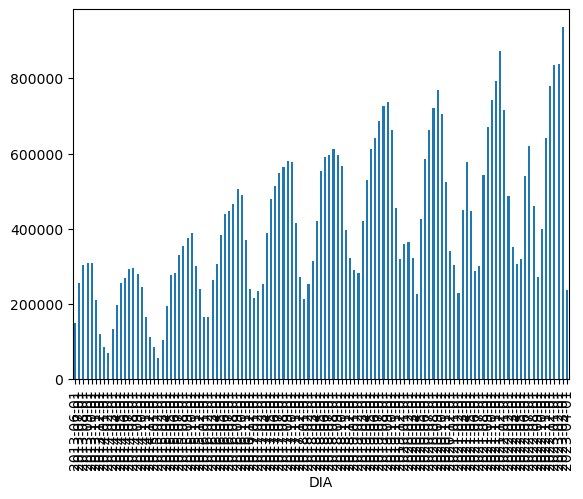

In [12]:
df_timeline.set_index("DIA", inplace=True)
df_timeline["NUM_TRIPS"].plot(kind="bar")

## Viajes por dia de la Semana

In [13]:
df_sql_week_day =  session.sql("Select WEEK_DAY, NUM_TRIPS from CITIBIKE.DEMO.VIEW_DAY_OF_WEEK")

In [14]:
df_week_day = df_sql_week_day.toPandas()

In [15]:
df_week_day

,WEEK_DAY,NUM_TRIPS
0,0,6574658
1,1,6013864
2,2,6928155
3,3,7376263
4,4,7579206
5,5,7342757
6,6,7250176


<Axes: xlabel='WEEK_DAY'>

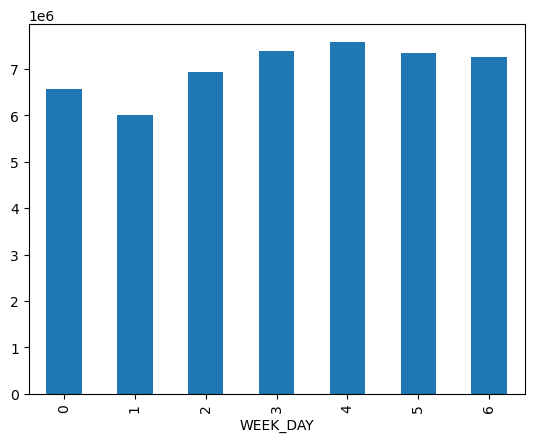

In [16]:
df_week_day.set_index("WEEK_DAY", inplace=True)
df_week_day["NUM_TRIPS"].plot(kind="bar")

### Viajes por hora del dia

In [17]:
df_sql_hour_of_day =  session.sql("Select HOUR_OF_DAY, NUM_TRIPS from CITIBIKE.DEMO.VIEW_HOUR_OF_DAY")

In [18]:
df_hour_of_day = df_sql_hour_of_day.toPandas()

In [19]:
df_hour_of_day[:24]

,HOUR_OF_DAY,NUM_TRIPS
0,0,504923
1,1,289886
2,2,177698
3,3,116620
4,4,106401
5,5,292774
6,6,997696
7,7,2065596
8,8,3390731
9,9,2874466


In [20]:
df_hour_of_day["NUM_TRIPS"].max()

4753704

In [21]:
df_hour_of_day[df_hour_of_day["NUM_TRIPS"]==4753704]


,HOUR_OF_DAY,NUM_TRIPS
17,17,4753704


<Axes: >

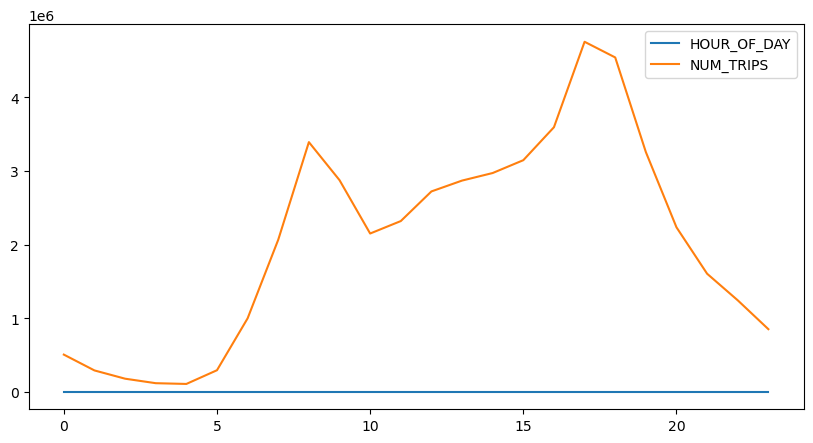

In [22]:
df_hour_of_day.plot(figsize=(10,5))

In [23]:
# dir(df_sql)

### Rutas - Origen - Destino

In [24]:
df_PopularRoutes.head()


,START_STATION_ID,END_STATION_ID,NUM_TRIPS,AVG_DURATION_MINS
0,2006,2006,1157967,44.49
1,281,281,568577,51.50
2,3203,3186,489242,7.49
3,514,426,489045,23.49
4,435,509,481434,6.74


In [25]:
df_PopularRoutes["NUM_TRIPS"].max()

# datos[datos["Age"]==10]

1157967

# Definicion de la tabla viajes

In [26]:

df_definicionT = session.sql("SELECT GET_DDL('table', 'TRIPS')")
pdf_definicionT = df_definicionT.to_pandas()
print(pdf_definicionT.values[:1][0][0])


create or replace TABLE TRIPS (
	TRIPID NUMBER(38,0) autoincrement,
	V VARIANT
);


In [27]:
df_definicionV = session.sql("SELECT GET_DDL('view', 'TRIPS_VW')")
pdf_definicionV = df_definicionV.to_pandas()
print(pdf_definicionV.values[:1][0][0])


create or replace view TRIPS_VW(
	TRIPID,
	STARTTIME,
	ENDTIME,
	DURATION,
	START_STATION_ID,
	END_STATION_ID,
	BIKEID,
	BIKE_TYPE,
	RIDERID,
	RIDER_NAME,
	DOB,
	GENDER,
	MEMBER_TYPE,
	PAYMENT,
	PAYMENT_TYPE,
	PAYMENT_NUM
) as select 
    tripid,
    v:STARTTIME::timestamp_ntz starttime,
    v:ENDTIME::timestamp_ntz endtime,
    datediff('minute', starttime, endtime) duration,
    v:START_STATION_ID::integer start_station_id,
    v:END_STATION_ID::integer end_station_id,
    v:BIKE.BIKEID::string bikeid,
    v:BIKE.BIKE_TYPE::string bike_type,
    v:RIDER.RIDERID::integer riderid,
    v:RIDER.FIRST_NAME::string || ' ' || v:RIDER.LAST_NAME::string rider_name,
    to_date(v:RIDER.DOB::string, 'YYYY/MM/DD') dob,
    v:RIDER.GENDER::string gender,
    v:RIDER.MEMBER_TYPE::string member_type,
    v:RIDER.PAYMENT.TYPE::string payment,
    ifnull(v:RIDER.PAYMENT.CC_TYPE::string, 
      v:RIDER.PAYMENT.PHONE_TYPE::string) payment_type,
    ifnull(v:RIDER.PAYMENT.PHONE_NUM::string,
      v:RIDE

In [28]:
### Exportar Viajes por Hora

In [29]:
df_hour_of_day 

,HOUR_OF_DAY,NUM_TRIPS
0,0,504923
1,1,289886
2,2,177698
3,3,116620
4,4,106401
5,5,292774
6,6,997696
7,7,2065596
8,8,3390731
9,9,2874466


In [30]:
df_hour_of_day.to_csv("C:\\Users\\user\\\Documents\\GitHub\\TareasRoel\\df_hour_of_day2.csv", header=True, index=True)

In [31]:
### Generó el archivo con éxito

### Creating a Snowflake User-Defined-Table-Function (UDTF)

In [32]:
## from snowflake.snowpark.types import IntegerType, StructField, StructType
## from snowflake.snowpark.functions import udtf, lit
## class GeneratorUDTF:
##     def process(self, n):
##         for i in range(n):
##             yield (i, )
## generator_udtf = udtf(GeneratorUDTF, output_schema=StructType([StructField("number", IntegerType())]), input_types=[IntegerType()])

In [33]:
## Call the function.
## session.table_function(generator_udtf(lit(3))).collect()  # Query it by calling it
##[Row(NUMBER=0), Row(NUMBER=1), Row(NUMBER=2)]
## session.table_function(generator_udtf.name, lit(3)).collect()  # Query it by using the name
##[Row(NUMBER=0), Row(NUMBER=1), Row(NUMBER=2)]

## Fin del Proyecto - Continuara